In [1]:
import os
import pickle
import logging

import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import jax
from numpyro.infer import Predictive, SVI, Trace_ELBO

from hbmep.config import Config
from hbmep.model.utils import Site as site

from paper.utils import setup_logging
from _models import HierarchicalBayesianModel, SVIHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
    INFERENCE_FILE
)

PLATFORM = "cuda"
jax.config.update("jax_platforms", PLATFORM)

logger = logging.getLogger(__name__)

BUILD_DIR = os.path.join(BUILD_DIR, "cc_position_charge")
os.makedirs(BUILD_DIR, exist_ok=True)
setup_logging(
    dir=BUILD_DIR,
    fname="cc_postition_charge"
)

COLUMNS = ["participant", "compound_position", "compound_charge_params"]
FEATURES = ["participant", ["compound_position", "compound_charge_params"]]
COMPLETE_CASES = [
    ('C7L-C7M', '20-0-80-25'),
    ('C7L-C7M', '50-0-50-0'),
    ('C7L-C7M', '50-0-50-100'),
    ('C7M-C7L', '20-0-80-25'),
    ('C7M-C7L', '50-0-50-0'),
    ('C7M-C7L', '50-0-50-100')
]


2024-07-09 16:41:42,187 - paper.utils.utils - INFO - Logging to /home/vishu/repos/rat-mapping-paper/reports/j-shap/cc_position_charge/cc_postition_charge.log


In [2]:
def _process_data(df, keep_combinations):
    ind = df[COLUMNS[1:]].apply(tuple, axis=1).isin(keep_combinations)
    df = df[ind].reset_index(drop=True).copy()
    return df


In [3]:
df = pd.read_csv(DATA_PATH)
logger.info("Processing data ...")
df = _process_data(df=df, keep_combinations=COMPLETE_CASES)
logger.info(f"Processed df shape: {df.shape}")

config = Config(toml_path=TOML_PATH)
config.FEATURES = FEATURES
config.BUILD_DIR = BUILD_DIR
# ['LADM', 'LBiceps', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps']
config.RESPONSE = ["LTriceps", "LECR", "LFCR"]
config.RESPONSE = ["LECR"]
# config.RESPONSE = ['LBiceps', 'LDeltoid', 'LTriceps']
# config.RESPONSE = ['LBiceps', 'LTriceps']

# subset = [
#     "amap01",
#     "amap02",
#     "amap03",
#     # "amap05",
#     # "amap06",
#     # "amap07",
#     # "amap08",
# ]
# ind = (
#     df["participant"]
#     .isin(subset)
# )
# df = df[ind].reset_index(drop=True).copy()

model = SVIHierarchicalBayesianModel(config=config)
df, encoder_dict = model.load(df=df)

# Run inference
guide, svi_result = model.run_inference(
    df=df,
    num_steps = int(2e6),
    step_size = 1e-3,
    num_particles = 100,
    subsample_size = 20
)


2024-07-09 16:41:42,276 - __main__ - INFO - Processing data ...
2024-07-09 16:41:42,302 - __main__ - INFO - Processed df shape: (2538, 44)


2024-07-09 16:41:42.439549: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
num_samples = (model.mcmc_params["num_samples"] * model.mcmc_params["num_chains"]) // model.mcmc_params["thinning"]
num_samples

predictive = Predictive(
    guide,
    params=svi_result.params,
    num_samples=num_samples
)

posterior_samples_ = predictive(model.rng_key, *model._get_regressors(df=df))
posterior_samples_ = {u: np.array(v) for u, v in posterior_samples_.items()}
posterior_samples = posterior_samples_.copy()
if site.outlier_prob in posterior_samples:
    posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Predictions and recruitment curves
prediction_df = model.make_prediction_dataset(df=df)
predictive = Predictive(
    model._model,
	posterior_samples,
	params=svi_result.params,
	num_samples=num_samples
)
posterior_predictive = predictive(model.rng_key, *model._get_regressors(df=prediction_df))
posterior_predictive = {u: np.array(v) for u, v in posterior_predictive.items()}

if site.a not in posterior_samples:
    posterior_samples[site.a] = posterior_predictive[site.a]

model.render_recruitment_curves(
    df=df,
    encoder_dict=encoder_dict,
    posterior_samples=posterior_samples,
    prediction_df=prediction_df,
    posterior_predictive=posterior_predictive
)


2024-07-09 16:36:09,533 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2024-07-09 16:36:12,413 - hbmep.plotter.core - INFO - Rendering recruitment curves ...
2024-07-09 16:36:26,389 - hbmep.plotter.core - INFO - Saved to /home/vishu/repos/rat-mapping-paper/reports/j-shap/cc_position_charge/recruitment_curves.pdf
2024-07-09 16:36:26,389 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 13.98 sec


2024-07-09 16:36:26,511 - __main__ - INFO - Losses plot saved at /home/vishu/repos/rat-mapping-paper/reports/j-shap/cc_position_charge/losses.png


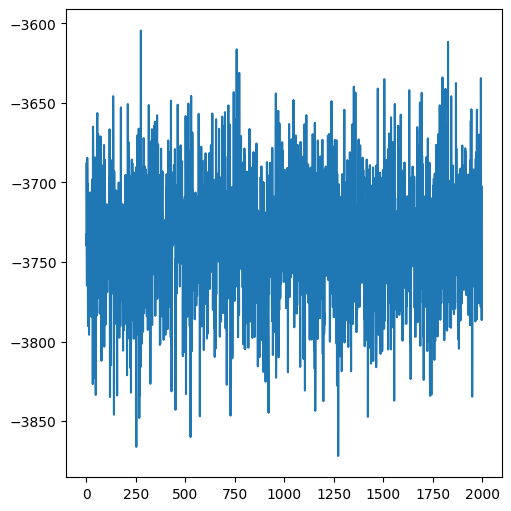

In [ ]:
# Save losses plot
losses = svi_result.losses

fig, axes = plt.subplots(
    1, 1, figsize=(5, 5), constrained_layout=True, squeeze=False
)
ax = axes[0, 0]
sns.lineplot(x=range(len(losses[-2000:])), y=losses[-2000:], ax=ax)
dest = os.path.join(model.build_dir, "losses.png")
fig.savefig(dest)
logger.info(f"Losses plot saved at {dest}")


In [ ]:
a_delta_loc = posterior_samples["a_delta_loc"]
print(a_delta_loc.shape)

conditions = encoder_dict[model.features[1]].inverse_transform(
    sorted(df[model.features[1]].unique())
).tolist()

conditions


(4000, 5, 1)


['C7L-C7M___20-0-80-25',
 'C7L-C7M___50-0-50-0',
 'C7L-C7M___50-0-50-100',
 'C7M-C7L___20-0-80-25',
 'C7M-C7L___50-0-50-0',
 'C7M-C7L___50-0-50-100']

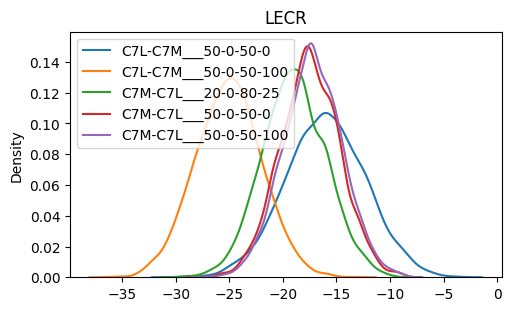

In [ ]:
nrows, ncols = 1, model.n_response
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 3),
    constrained_layout=True,
    squeeze=False,
    sharex=True
)

for j, response in enumerate(model.response):
    for i, condition in enumerate(conditions[1:]):
        ax = axes[0, j]
        samples = a_delta_loc[:, i, j]
        sns.kdeplot(samples, ax=ax, label=condition)
        ax.set_title(model.response[j])
        ax.tick_params(axis="x", labelbottom=True)

axes[0, 0].legend()


In [ ]:
a_delta_loc.shape


(4000, 5, 1)